In [1]:
# =============================================================================
# Title   : MultiLayer Perceptron (MLP) - Regression
# Course  : Models and Methods of Intelligent Systems
# Author  : Dr.-Ing. Cesar Hernando Valencia Niño
# =============================================================================

# =========================
# SETUP COMÚN (Colab)
# =========================
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

np.random.seed(42)

def make_series(n=2500, noise=0.15):
    """
    Serie sintética: suma de senos + tendencia suave + ruido.
    Ideal para probar regresión con ventanas.
    """
    t = np.arange(n)
    y = (0.6*np.sin(2*np.pi*t/50) +
         0.3*np.sin(2*np.pi*t/200) +
         0.0015*t +
         noise*np.random.randn(n))
    return y.astype(np.float32)

def make_windows(y, lookback=30, horizon=1):
    """
    Ventanas tipo supervised: X[t-lookback:t] -> y[t+horizon-1]
    """
    X, Y = [], []
    for i in range(lookback, len(y)-horizon+1):
        X.append(y[i-lookback:i])
        Y.append(y[i+horizon-1])
    X = np.array(X, dtype=np.float32)  # (N, lookback)
    Y = np.array(Y, dtype=np.float32)  # (N,)
    return X, Y

def train_test_split_time(X, Y, train_ratio=0.8):
    n = len(X)
    ntr = int(n*train_ratio)
    return X[:ntr], Y[:ntr], X[ntr:], Y[ntr:]

def metrics(y_true, y_pred, eps=1e-8):
    mae = mean_absolute_error(y_true, y_pred)
    rmse = np.sqrt(mean_squared_error(y_true, y_pred))
    mape = np.mean(np.abs((y_true - y_pred) / (np.abs(y_true) + eps))) * 100
    r2 = r2_score(y_true, y_pred)
    return {"MAE": mae, "RMSE": rmse, "MAPE(%)": mape, "R2": r2}

def plot_results(y_true, y_pred, title=""):
    plt.figure()
    plt.plot(y_true, label="Real")
    plt.plot(y_pred, label="Predicción")
    plt.title(title)
    plt.xlabel("Tiempo (muestras test)")
    plt.ylabel("y")
    plt.legend()
    plt.show()

    resid = y_true - y_pred
    plt.figure()
    plt.plot(resid)
    plt.title(f"Residuales (Real - Pred) | {title}")
    plt.xlabel("Tiempo (muestras test)")
    plt.ylabel("Error")
    plt.show()

# -------------------------
# DATOS + VENTANEO
# -------------------------
lookback = 40
horizon = 1
y = make_series(n=3000, noise=0.18)

X, Y = make_windows(y, lookback=lookback, horizon=horizon)
Xtr, Ytr, Xte, Yte = train_test_split_time(X, Y, train_ratio=0.8)

# Escalado (MUY recomendado para redes)
scaler_x = StandardScaler()
scaler_y = StandardScaler()

Xtr_s = scaler_x.fit_transform(Xtr)
Xte_s = scaler_x.transform(Xte)

Ytr_s = scaler_y.fit_transform(Ytr.reshape(-1,1)).ravel()
Yte_s = scaler_y.transform(Yte.reshape(-1,1)).ravel()

print("Shapes:", Xtr_s.shape, Ytr_s.shape, Xte_s.shape, Yte_s.shape)


Shapes: (2368, 40) (2368,) (592, 40) (592,)


Epoch 1/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 8ms/step - loss: 0.3074 - val_loss: 0.0440
Epoch 2/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0652 - val_loss: 0.0365
Epoch 3/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0510 - val_loss: 0.0408
Epoch 4/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0459 - val_loss: 0.0358
Epoch 5/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0446 - val_loss: 0.0359
Epoch 6/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0428 - val_loss: 0.0367
Epoch 7/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0417 - val_loss: 0.0378
Epoch 8/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0400 - val_loss: 0.0358
Epoch 9/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0407 - val_loss: 0.0346
Epoch 10/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0375 - val_loss: 0.0347
Epoch 11/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - loss: 0.0396 - val_loss: 0.0355
Epoch 12/25
34/34 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - loss: 0.0404 - val_lo

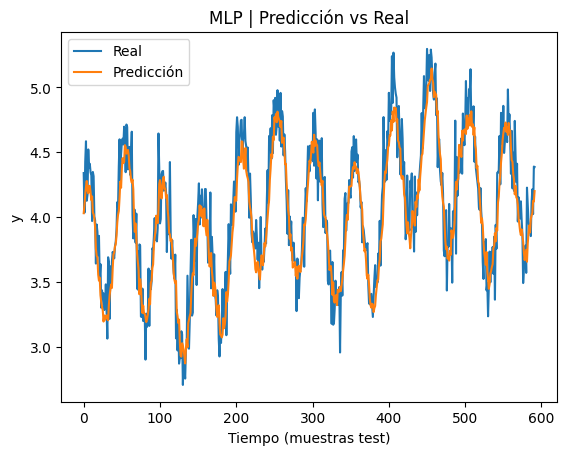

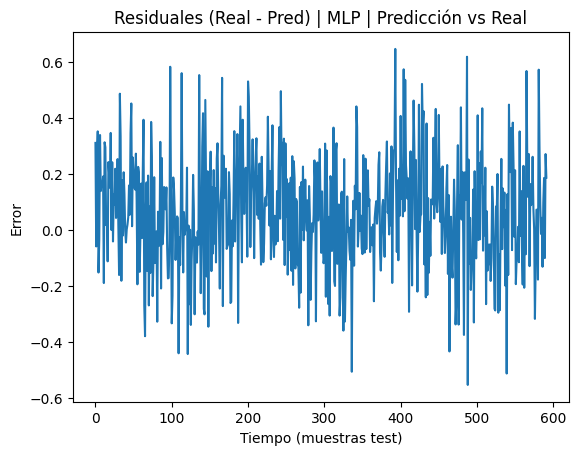

In [2]:
# =========================
# MLP para regresión
# =========================
import tensorflow as tf
from tensorflow.keras import layers, models

tf.random.set_seed(42)

# Hiperparámetros
epochs = 25
batch_size = 64
lr = 1e-3

model = models.Sequential([
    layers.Input(shape=(lookback,)),
    layers.Dense(128, activation="relu"),
    layers.Dropout(0.2),
    layers.Dense(64, activation="relu"),
    layers.Dense(1)
])

model.compile(optimizer=tf.keras.optimizers.Adam(lr),
              loss="mse")

hist = model.fit(Xtr_s, Ytr_s, validation_split=0.1,
                 epochs=epochs, batch_size=batch_size, verbose=1)

# Predicción
Ypred_s = model.predict(Xte_s).ravel()
Ypred = scaler_y.inverse_transform(Ypred_s.reshape(-1,1)).ravel()

# Métricas
m = metrics(Yte, Ypred)
print("MLP métricas:", m)

# Gráficas
plot_results(Yte, Ypred, title="MLP | Predicción vs Real")
